In [1]:
import pandas as pd
import numpy as np
from datasets import Dataset
import torchaudio
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("/kaggle/input/sanskrit-speech-recognition/sanskrit/sanskrit_fairseq/train.tsv", sep = "\t")

In [3]:
df.reset_index(names='index', inplace=True)

In [4]:
df.head()

,index,/nlsasfs/home/ai4bharat/gramesh/speechteam/github_repos/indicAlignment/data/newsonair_v5/sanskrit
0,NSD-Sanskrit-Sanskrit-1810-1815-2019629185238/...,115200
1,NSD-Sanskrit-Sanskrit-1810-1815-2019629185238/...,200000
2,NSD-Sanskrit-Sanskrit-1810-1815-2019629185238/...,228480
3,NSD-Sanskrit-Sanskrit-1810-1815-2019629185238/...,66240
4,NSD-Sanskrit-Sanskrit-1810-1815-2019629185238/...,149440


In [5]:
df.rename(columns = {
    df.columns[0] : "path",
    df.columns[1] : "sample_path"
}, inplace = True)

In [6]:
df.head()

,path,sample_path
0,NSD-Sanskrit-Sanskrit-1810-1815-2019629185238/...,115200
1,NSD-Sanskrit-Sanskrit-1810-1815-2019629185238/...,200000
2,NSD-Sanskrit-Sanskrit-1810-1815-2019629185238/...,228480
3,NSD-Sanskrit-Sanskrit-1810-1815-2019629185238/...,66240
4,NSD-Sanskrit-Sanskrit-1810-1815-2019629185238/...,149440


In [7]:
def read_wrd_file(wrd_file_path):
    with open(wrd_file_path, 'r') as f:
        transcriptions = f.readlines()
    return [line.strip() for line in transcriptions]

In [8]:
transcriptions = read_wrd_file("/kaggle/input/sanskrit-speech-recognition/sanskrit/sanskrit_fairseq/train.wrd")

In [9]:
transcriptions[0]

'जीविंशति इति राष्ट्राणि वैश्विकार्थिकसमाह्वानाय ऐक्यमत्येन साहाय्याचरणाय प्रतिबद्धानि'

In [10]:
df['transcription'] = transcriptions

In [11]:
df["path"] = "/kaggle/input/sanskrit-speech-recognition/sanskrit/Audio files/" + df["path"]

In [12]:
df["path"][0]

'/kaggle/input/sanskrit-speech-recognition/sanskrit/Audio files/NSD-Sanskrit-Sanskrit-1810-1815-2019629185238/sent_1.wav'

In [13]:
dataset = Dataset.from_pandas(df)

In [14]:
dataset

Dataset({
    features: ['path', 'sample_path', 'transcription'],
    num_rows: 9710
})

In [15]:
def load_audio(batch):
    speech_array, sampling_rate = torchaudio.load(batch['path'])
    if sampling_rate != 16000:
        resampler = torchaudio.transforms.Resample(sampling_rate, 16000)
        speech_array = resampler(speech_array)
    batch['speech'] = speech_array.squeeze().numpy()
    return batch

dataset = dataset.map(load_audio)

Map:   0%|          | 0/9710 [00:00<?, ? examples/s]

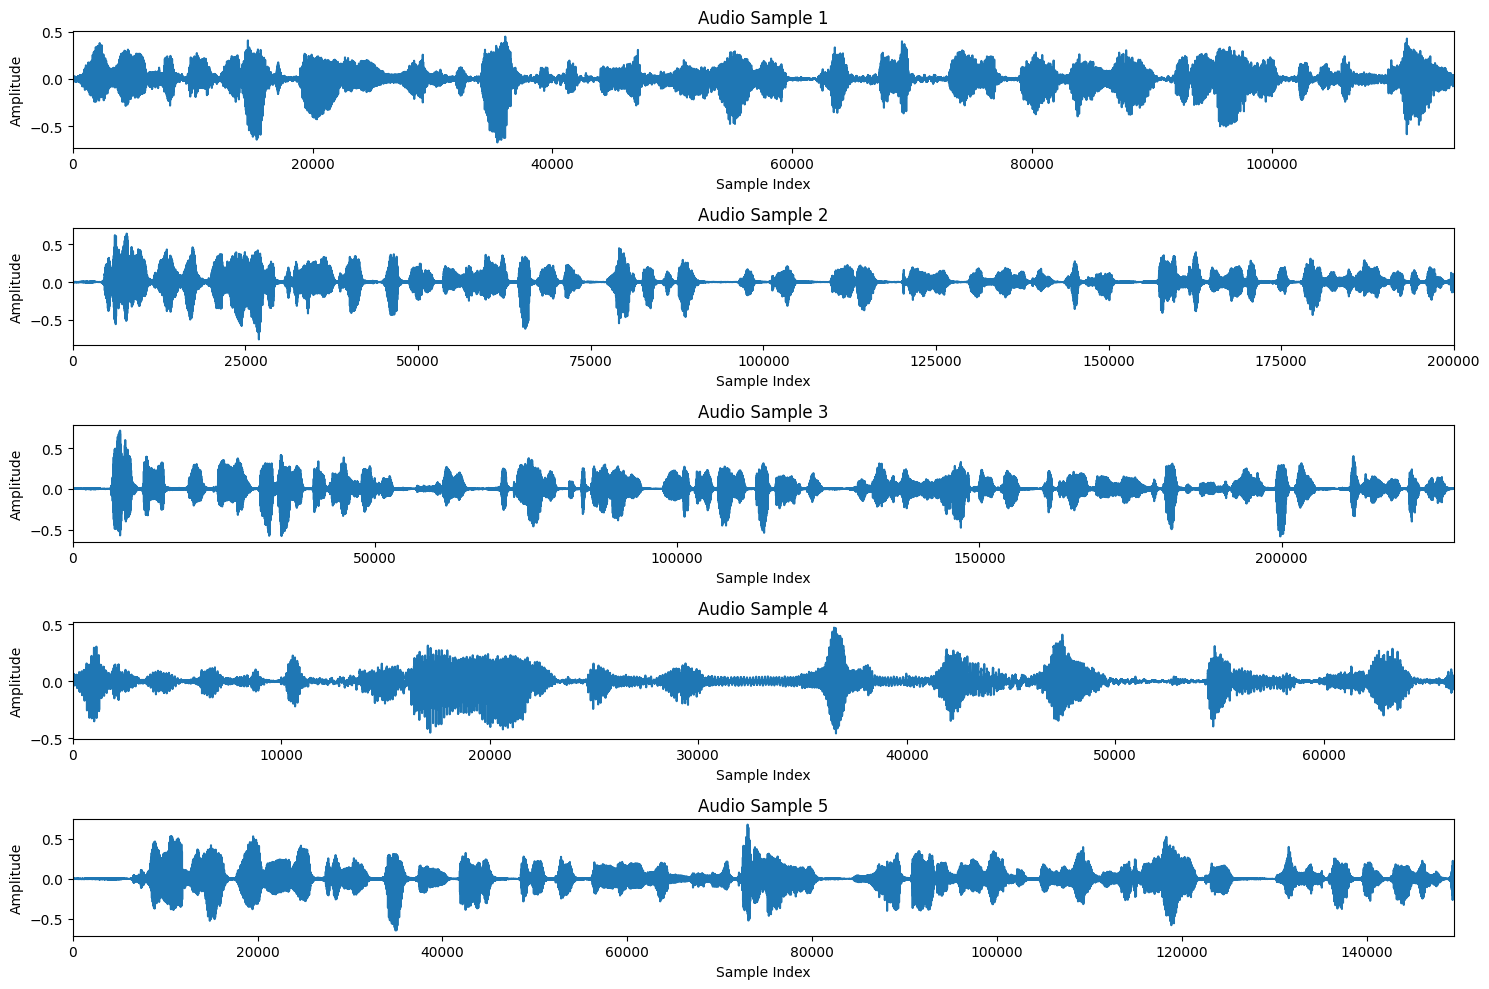

In [16]:
def plot_audio_samples(dataset, num_samples=5):
    plt.figure(figsize=(15, 10))
    
    for i in range(num_samples):

        audio_data = dataset[i]['speech']
        plt.subplot(num_samples, 1, i + 1)
        plt.plot(audio_data)
        plt.title(f'Audio Sample {i + 1}')
        plt.xlabel('Sample Index')
        plt.ylabel('Amplitude')
        plt.xlim(0, len(audio_data))
    
    plt.tight_layout()
    plt.show()


plot_audio_samples(dataset)

In [17]:
from transformers import WhisperProcessor, WhisperForConditionalGeneration

# Load the pre-trained Whisper model and processor (tokenizer)
processor = WhisperProcessor.from_pretrained("openai/whisper-small")
model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-small")

# Add a special token for Sanskrit if needed
processor.tokenizer.add_special_tokens({'additional_special_tokens': ['<sanskrit>']})
model.resize_token_embeddings(len(processor.tokenizer))

preprocessor_config.json:   0%|          | 0.00/185k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/283k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/836k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.48M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/494k [00:00<?, ?B/s]

normalizer.json:   0%|          | 0.00/52.7k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.19k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.97k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/967M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/3.87k [00:00<?, ?B/s]

Embedding(51866, 768, padding_idx=50257)

In [ ]:
def preprocess_text(batch):
    # Process the input speech
    inputs = processor(batch['speech'], sampling_rate=16000, return_tensors="pt").input_features
    
    # Process the transcription (target) using the tokenizer directly
    labels = processor.tokenizer(batch['transcription'], return_tensors="pt", padding="longest").input_ids
    
    # Store the input features and labels
    batch["input_features"] = inputs
    batch["labels"] = labels
    
    return batch

# Map the preprocessing function to the dataset
dataset = dataset.map(preprocess_text, remove_columns=["path", "transcription"])

Map:   0%|          | 0/9710 [00:00<?, ? examples/s]

In [ ]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

# Define training arguments
training_args = Seq2SeqTrainingArguments(
    output_dir="./whisper-finetuned-sanskrit",
    per_device_train_batch_size=8,
    evaluation_strategy="steps",
    num_train_epochs=3,
    save_steps=500,
    eval_steps=500,
    logging_steps=500,
    learning_rate=5e-5,
    save_total_limit=2,
    gradient_accumulation_steps=2,
    fp16=True,
)

# Initialize the Trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=dataset,
    tokenizer=processor.feature_extractor,  # Whisper uses feature extractor instead of tokenizer for audio
)

# Start fine-tuning
trainer.train()

In [ ]:
from datasets import load_metric

# Load WER metric
wer_metric = load_metric("wer")

def compute_metrics(pred):
    pred_ids = pred.predictions
    label_ids = pred.label_ids
    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    label_str = processor.batch_decode(label_ids, skip_special_tokens=True)

    wer = wer_metric.compute(predictions=pred_str, references=label_str)
    return {"wer": wer}

# Add this to the Trainer to compute during evaluation
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=dataset,
    eval_dataset=validation_dataset,  # Add validation set here
    tokenizer=processor.feature_extractor,
    compute_metrics=compute_metrics
)

In [ ]:
def transcribe_audio(audio_path):
    speech_array, _ = torchaudio.load(audio_path)
    input_features = processor(speech_array.squeeze().numpy(), sampling_rate=16000, return_tensors="pt").input_features
    generated_ids = model.generate(input_features)
    transcription = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return transcription

# Example usage
transcription = transcribe_audio('/kaggle/input/sanskrit-speech-recognition/sanskrit/Audio files/NSD-Sanskrit-Sanskrit-0655-0700-201910127951/sent_3.wav')
print(transcription)